# Electrical rock physics

In [55]:
#RP transforms 
import numpy as np
import matplotlib.pyplot as plt


def TDS_to_sigmaf(TDS,mTDS=1.4200556641030946,bTDS=332.7093594248108):
    '''
    Linear relationship of TDS to fluid resistivity
    input: 
        TDS in mg/L
        mTDS,bTDS: fitting params
    output: 
        sigma_f: fluid conductivity in S/m
    '''
    return (mTDS*TDS*1000 + bTDS)/1e4


def WS_sigma(sigma_f, por = 0.4, CEC=1,B0=4.5e-8, m=1.3):
    '''
    Waxman-Smits relationship for a clayey sand 
    input:
        sigma_f: fluid conductivity in S/m
        por: porosity
        CEC: cation exchange capacity (meq/g)
            1:smectite,  .2:Illite,  .02-.09:Kaolinite
        B0: fitting parameter (default value taken from Revil and Glover, 1998)
        m: Archie cementation exponent (0.5-2 for unconsolidated materials)
    returns:
        sigma_b: bulk conductivity in S/m
    '''
    rho_grain = 2650*1000 #g/m^3
    F = por**(-m)
    Qv = rho_grain*((1-por)/por)*CEC
    B = B0*(1-.6*np.exp(-sigma_f/.013))
    sigma_b = 1/F*(sigma_f + B*Qv)
    return sigma_b,B,Qv


def HSU(sigma1,sigma2,chi2):
    '''
    Hashin-Shtrikman upper bound
    input:
        sigma1: conductivity of the less conductive constituent
        sigma2: conductivity of the more conductive constituent
        chi2: volume fraction of the more conductive constituent
    returns:
        HSU
    '''
    return sigma2*(1 - (3*(1-chi2)*(sigma2-sigma1))/(3*sigma2 - chi2*(sigma2-sigma1)))

def RP_twostep(TDS,CF,**kwargs):
    '''
    RP relationship for upscaling
    1) Waxman-Smits relationship to estimate the conductivity of constituents:
        sigma_clay and sigma_sand
    2) Hashin-Shtrikman upper bound to predict global conductivity at the large scale 
    input:
        TDS (mg/L)
        CF: clay fraction at the upscaled volume
        **kwargs: fed to WS_sigma function
    returns:
        upscaled global conductivity weighted by clay fraction (in S/m)
    '''

    #kwargs fed to WS_sigma
    Cw = TDS_to_sigmaf(TDS)
    sigma_sand = WS_sigma(Cw,CEC=0,**kwargs)[0]
    sigma_clay = WS_sigma(Cw,CEC=1,**kwargs)[0]
    return HSU(sigma_sand,sigma_clay,CF)




Text(0.5, 0, 'TDS (mg/L)')

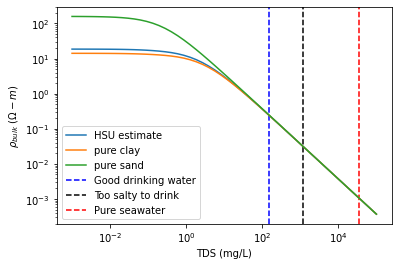

In [65]:
conc = np.logspace(-3,5,50)
cf = 0.8
por = 0.25
m=1.2
sigma_b = RP_twostep(conc,cf,por=por,m=m)

sigma_bs = RP_twostep(conc,0,por=por,m=m)
sigma_bc = RP_twostep(conc,1,por=por,m=m)

plt.loglog(conc,1/sigma_b,label='HSU estimate')
plt.loglog(conc,1/sigma_bc,label='pure clay')
plt.loglog(conc,1/sigma_bs,label='pure sand')

ylims = plt.ylim()
plt.vlines(150,ylims[0],ylims[1],colors='b',linestyle='dashed',label='Good drinking water')
plt.vlines(1200,ylims[0],ylims[1],colors='k',linestyle='dashed',label='Too salty to drink')
plt.vlines(35000,ylims[0],ylims[1],colors='r',linestyle='dashed',label='Pure seawater')

plt.legend()
plt.ylim(ylims)
plt.ylabel('$\\rho_{bulk}$ $(\Omega-m)$')
plt.xlabel('TDS (mg/L)')